Piotr Kuchta, Sebastian Soczawa

Laboratorium 3

# Temat: Interpolacja

Zadanie 1

Celem zadania jest zapoznanie się z zagadnieniem interpolacji, stosując je do interpolacji danych dotyczących Populacji Stanów Zjednoczonych na przestrzeni lat 1900-1980.

Na początku importujemy potrzebne biblioteki:

In [476]:
import numpy as np
import matplotlib.pyplot as plt

Definijumy funkcje bazowe podane w zadaniu:

In [477]:
def f1_val(x):
    return x
def f2_val(x):
    return (x-1900)
def f3_val(x):
    return (x-1940)
def f4_val(x):
    return (x-1940)/40

def f1(x,j):
    return x**j
def f2(x,j):
    return (x-1900)**j
def f3(x,j):
    return (x-1940)**j
def f4(x,j):
    return ((x-1940)/40)**j


Następnie funkcję tworzącą macierz Vandermonda

In [478]:
def vandermond(f,xs):
    n = len(xs)
    V = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            V[i][j] = f(xs[i], j)
    return V

Wprowadzamy dane years - lata ( 1900 - 1980), oraz pop - populacja w odpowiednich latach, następnie obliczamy macierz Vandermonda dla każdej z funkcji bazowych

In [479]:
years = np.array([1900,1910,1920,1930,1940,1950,1960,1970,1980])
pop = np.array([76212168,92228496,106021537,123202624,132164569,151325798,179323175,203302031,226542199])
# pop = np.array([76212168,92228496,106021537,123202624,132164569,1513257980,179323175,203302031,226542199])
v1 = vandermond(f1,years)
v2 = vandermond(f2,years)
v3 = vandermond(f3,years)
v4 = vandermond(f4,years)

Dla każdej z macierzy Vandermonde'a obliczamy współczynnik uwarunkowania

In [480]:
cond1 = np.linalg.cond(v1)
cond2 = np.linalg.cond(v2)
cond3 = np.linalg.cond(v3)
cond4 = np.linalg.cond(v4)

best_cond = min(cond1, cond2, cond3, cond4)

print("cond1 = ", cond1, "\ncond2 = ", cond2, "\ncond3 = ", cond3, "\ncond4 = ", cond4, "\nbest: ", best_cond)

cond1 =  5.03118434086647e+26 
cond2 =  6306532437721114.0 
cond3 =  9315536053440.451 
cond4 =  1605.4437004786996 
best:  1605.4437004786996


okazuje się, że najlepiej uwarunkowaną macierzą jest macierz stworzona na podstawie czwartej funkcji bazowej, na jej podstawie liczymy współczynniki wielomianu interpolacyjnego

In [481]:
c = np.dot(np.linalg.inv(v4), pop)
print(c)

[ 1.32164569e+08  4.61307656e+07  1.02716315e+08  1.82527130e+08
 -3.74614715e+08 -3.42668456e+08  6.06291250e+08  1.89175576e+08
 -3.15180235e+08]


Następnie przy pomocy shematu Hornera obliczamy wartości na przedziale [1900, 1990] w odstępach jednorocznych, dodatkowo obliczamy to samo dla danych zaokrąglonych do jednego miliona

Błąd względny ekstrapolacji:  0.6672864651416033
Błąd względny ekstrapolacji dla zaokrąglonych danych:  0.5617383472348729


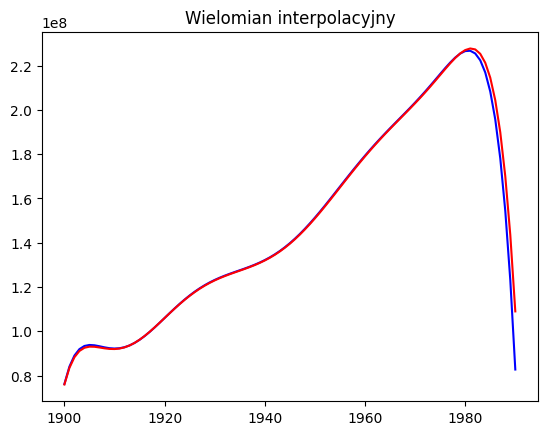

In [494]:
def horner(x,c):
    result = 0 
    for i in range(len(c)-1,-1,-1):
        result = (result*x) + c[i]
    return result
pop_round = np.round(pop,-6)
c_round = np.dot(np.linalg.inv(v4),pop_round)
x_vals = np.arange(1900, 1991, 1)
y_vals = np.zeros(91)
y_vals_round = np.zeros(91)

for i in range(len(x_vals)):
    y_vals[i] = horner(f4_val(x_vals[i]), c)
    y_vals_round[i] = horner(f4_val(x_vals[i]), c_round)

extr_1990 = horner(f4_val(1990), c)
extr_1990_round = horner(f4_val(1990), c_round)
exact_1990 = 248709873
print("Błąd względny ekstrapolacji: ", abs(extr_1990 - exact_1990)/exact_1990)
print("Błąd względny ekstrapolacji dla zaokrąglonych danych: ", abs(extr_1990_round - exact_1990)/exact_1990)


plt.plot(x_vals, y_vals, color="blue")
plt.plot(x_vals, y_vals_round, color="red")
plt.title('Wielomian interpolacyjny')
plt.show()


Wielomian dla zaokrąglonych danych, błąd względny ekstrapolacji jest mniejszy dla zaokrąglonych danych, jednak wydaje się to być przypadkowe

Definiujemy funkcję obliczającą wartość wielomianu interpolacyjnego Lagranga dla podanego argumentu

In [483]:
def LagrangeInterpolation(xs, ys, x):
    sol = 0
    t = 0

    for i in range(0, len(xs)):
        t = 1
        for j in range(0, len(ys)):
            if(j != i):
                t = t*((x-xs[j])/(xs[i]-xs[j]))
        sol += t*ys[i]

    return sol

Następnie przeprowadzamy ekstrapolację za pomocą wielomianu interpolacyjnego Lagrange'a i obliczamy wartości tego wielomianu w odstępach jednorocznych, wyniki przedstawia poniższy wykres.

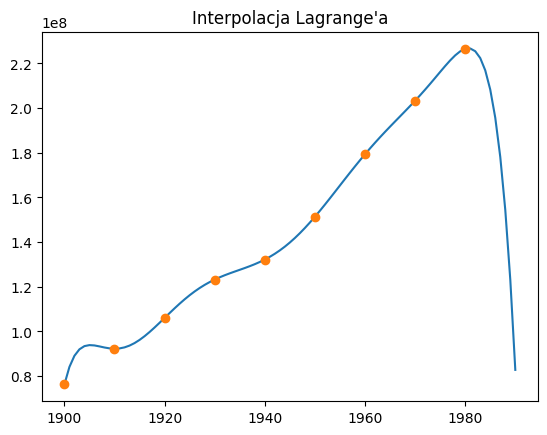

In [490]:
x_vals_L = np.arange(1900, 1991, 1)
y_vals_L = np.zeros(91)
for i in range(len(x_vals_L)):
    y_vals_L[i] = LagrangeInterpolation(years, pop, x_vals_L[i])

plt.plot(x_vals_L, y_vals_L)
plt.plot(years, pop, 'o')
plt.title('Interpolacja Lagrange\'a')
plt.show()

Następnie definiujemy funkcję coefficients, która wyznacza współczynnik wielomianu interpolacyjnego Newtona, oraz funkcję newton - obliczającą wartość wielomianu dla zadanegoo punktu


In [485]:
def coefficients(x, y):
    """
    x: list or np array contanining x data points
    y: list or np array contanining y data points
    """
    m = len(x)
    x = np.array(x,dtype=float)
    a = np.array(y,dtype=float)
    for k in range(1, m):
        a[k:m] = (a[k:m] - a[k - 1])/(x[k:m] - x[k - 1])
    return a


def newton(c,x_values, x):
    """
    c: coefficients
    x_data: data points at x
    x: evaluation point(s)
    """
    n = len(x_values) - 1  # Degree of polynomial
    result = 0
    for i in range(len(x_values)-1,-1,-1):
        result = result*(x-x_values[i]) + c[i]
    return result


Za pomocą powyższych funkcji obliczamy wartości wielomianu interpolacyjnego Newtona dla lat z przedziału [1900-1990]. Wyniki zostały przedstawione na wykresie

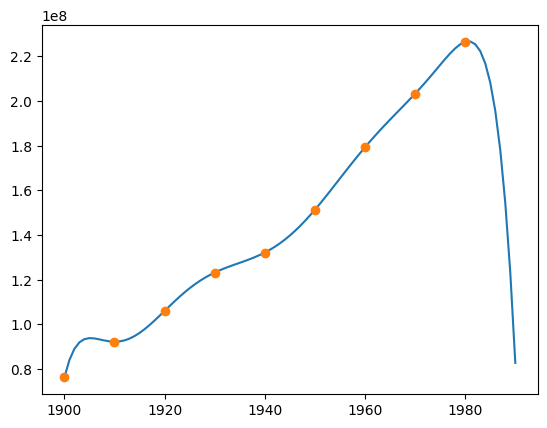

In [486]:
years = np.array([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980])
pop = np.array([76212168,92228496,106021537,123202624,132164569,151325798,179323175,203302031,226542199])

x_vals_N = np.arange(1900, 1991, 1)
y_vals_N = np.zeros(91, dtype=float)

c_newton = coefficients(years,pop)
for i in range(len(x_vals_N)):
    y_vals_N[i] = newton(c_newton,years,x_vals_N[i])

plt.plot(x_vals_N, y_vals_N)
plt.plot(years, pop, 'o')
plt.show()

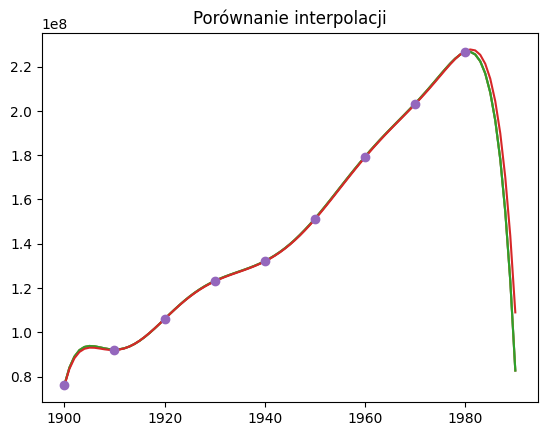

In [492]:
plt.plot(x_vals_N, y_vals_N)
plt.plot(x_vals_L, y_vals_L)
plt.plot(x_vals, y_vals)
plt.plot(x_vals, y_vals_round)
plt.plot(years, pop, 'o')
plt.title("Porównanie interpolacji")
plt.show()

W tym przykładzie użyta metoda Interpolacji praktycznie nie wpłynęła na otrzymywane wyniki, dopiero zaookrąglenie danych dało nieznacznie inne wyniki interpolacji

# Bibliografia

 - https://home.agh.edu.pl/~byrska/src/MN_2020/3_Interpolacja.pdf
 - https://eia.pg.edu.pl/documents/184139/40421150/TI_LAB_5_Material_pomocniczy_a.pdf
 - https://pl.wikipedia.org/wiki/Interpolacja_wielomianowa
